In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from tqdm.notebook import tqdm
from modelbase.ode import Model, Simulator

import models


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


def updating_parameter_scan(s, name, values, y0):
    y0 = y0.copy()
    conc = {}
    flux = {}
    for value in tqdm(values, total=len(values)):
        s.clear_results()
        s.initialise(y0)
        s.update_parameter(name, value)
        try:
            t, y = s.simulate(100_000)
            conc[value] = dict(s.get_full_results_df().iloc[-1])
            flux[value] = dict(s.model.get_fluxes_df(y[-1]).iloc[-1])
            y0 = get_new_y0(s)
        except:
            break
    return pd.DataFrame(conc).T, pd.DataFrame(flux).T


def compartmentalise_groups(base_groups: list[str]) -> list[str]:
    groups = []
    for group in base_groups:
        groups.append([f"{i}_meso" for i in group])
        groups.append([f"{i}_bs" for i in group])
    return groups


def is_steady(v, cpd):
    return np.isclose(
        sum(
            v.iloc[-1][k] * val for k, val in m.stoichiometries_by_compounds[cpd].items()
        ),
        0,
    )


def plot_reactions_of_cpd(v, cpd, ax=None):
    rxns = v.loc[:, list(m.stoichiometries_by_compounds[cpd])]
    return rxns.plot(ax=ax, ylim=(np.min(rxns.values) * 0.9, np.max(rxns.values) * 1.1))


def plot_cpd_rhs(v, cpd, ax=None):
    return (
        pd.DataFrame(v[k] * val for k, val in m.stoichiometries_by_compounds[cpd].items())
        .sum()
        .plot(ax=ax, label=cpd)
    )

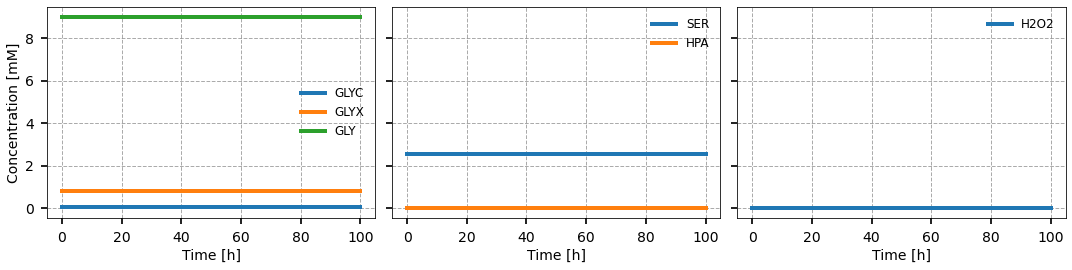

In [2]:
y0_yokota = {
    "GLYC": 0.08999999999999997,
    "GLYX": 0.7964601794673895,
    "GLY": 8.999999975082668,
    "SER": 2.538560856085531,
    "HPA": 0.009782608672218024,
    "H2O2": 0.010880542843616853,
}

m = models.get_yokota()
s = Simulator(m)
s.initialise(y0_yokota)
t, y = s.simulate(100)
fig, ax = s.plot_grid(
    [
        ["GLYC", "GLYX", "GLY"],
        ["SER", "HPA"],
        ["H2O2"],
    ],
    xlabels="Time [h]",
    ylabels="Concentration [mM]",
)
fig.tight_layout()
plt.show()

In [3]:
from models.shared_rate_functions import mass_action_2s

The rate constant for decarboxylation of glyoxylate with H2O2 (7.5 L mol-1 s-1) was higher than that describing reaction with hydroxypyruvate and H2O2 (3.26 mol-1 s-1).

A significant divergence was observed after a shift to high light. The H2O2 level was elevated by ~50% in cat2 and was reduced by ~40% in WT (Figure 7). 

In [15]:
def add_nonenzymatic_decarboxylations(
    m: Model,
    c_per: str = "",
    tissue: str = "",
) -> Model:
    """The Keqs of these reactions are crazy high, we really can model them as irreversible"""
    m.add_parameters(
        {
            "kf_glyoxylate_decarboxylation": 1e9,  # [1/mM * H]
            "kf_hpa_decarboxylation": 1e9,  # [1/mM * H]
        }
    )
    m.add_reaction(
        rate_name=f"glyoxylate_decarboxylation{c_per}{tissue}",
        function=mass_action_2s,
        stoichiometry={
            f"GLYX{c_per}{tissue}": -1,
            f"H2O2{c_per}{tissue}": -1,
            # f"formate{c1}": 1,
            # f"CO2{c1}": 1,
        },
        parameters=["kf_glyoxylate_decarboxylation"],
    )
    m.add_reaction(
        rate_name=f"hpa_decarboxylation{c_per}{tissue}",
        function=mass_action_2s,
        stoichiometry={
            f"HPA{c_per}{tissue}": -1,
            f"H2O2{c_per}{tissue}": -1,
            f"GLYC{c_per}{tissue}": 1,
            # f"CO2{c1}": 1,
        },
        parameters=["kf_hpa_decarboxylation"],
    )
    return m


def update_nonenzymatic_decarboxylations_dynamic_co2(
    m: Model,
    c_chl: str = "",
    c_per: str = "",
    tissue: str = "",
) -> Model:
    m.update_reaction(
        rate_name=f"glyoxylate_decarboxylation{c_per}{tissue}",
        stoichiometry={
            f"GLYX{c_per}{tissue}": -1,
            f"H2O2{c_per}{tissue}": -1,
            # f"formate{c1}": 1,
            f"CO2{c_chl}{tissue}": 1,
        },
    )
    m.update_reaction(
        rate_name=f"hpa_decarboxylation{c_per}{tissue}",
        stoichiometry={
            f"HPA{c_per}{tissue}": -1,
            f"H2O2{c_per}{tissue}": -1,
            f"GLYC{c_chl}{tissue}": 1,
            f"CO2{c_chl}{tissue}": 1,
        },
    )
    return m

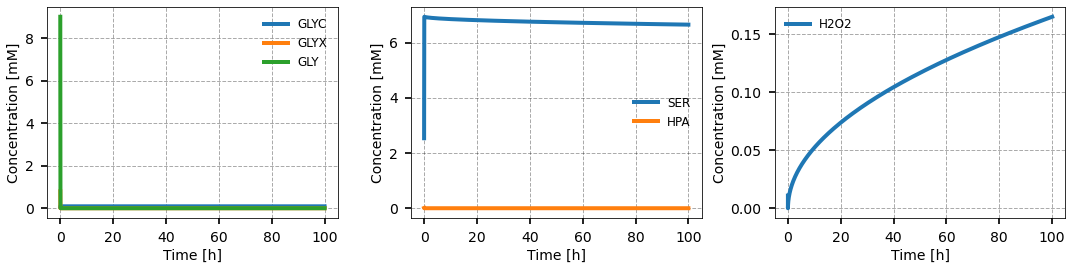

In [16]:
y0_yokota = {
    "GLYC": 0.08999999999999997,
    "GLYX": 0.7964601794673895,
    "GLY": 8.999999975082668,
    "SER": 2.538560856085531,
    "HPA": 0.009782608672218024,
    "H2O2": 0.010880542843616853,
}

m = models.get_yokota()
m.remove_reaction("catalase")
m = add_nonenzymatic_decarboxylations(m)
s = Simulator(m)
s.initialise(y0_yokota)
t, y = s.simulate(100)
fig, ax = s.plot_grid(
    [
        ["GLYC", "GLYX", "GLY"],
        ["SER", "HPA"],
        ["H2O2"],
    ],
    xlabels="Time [h]",
    ylabels="Concentration [mM]",
    sharey=False,
)
fig.tight_layout()
plt.show()

v = s.get_fluxes_df()
c = s.get_full_results_df()

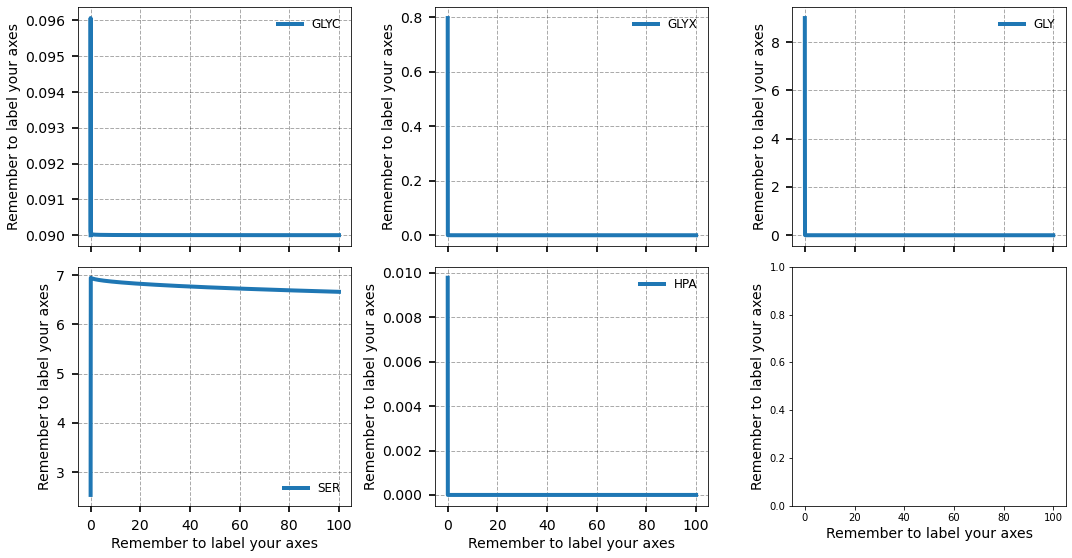

In [17]:
fig, axs = s.plot_grid(
    [
        ["GLYC"],
        ["GLYX"],
        ["GLY"],
        ["SER"],
        ["HPA"],
    ],
    ncols=3,
    sharey=False,
)

<AxesSubplot:>

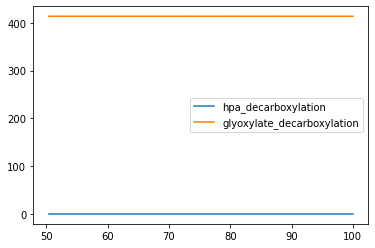

In [18]:
v.loc[50:, ["hpa_decarboxylation", "glyoxylate_decarboxylation"]].plot()

## Notes: 

- H2O2 levels are increasing too much, but both HPA and GLYX are essentially zero. There must be more to this. Reversibility?

# Reversible model

In [19]:
m = models.get_yokota()

m.add_parameters(
    {
        "keq_phosphoglycolate_phosphatase": 3.1e5,
        "keq_glycolate_oxidase": 3e15,
        "keq_glycine_transaminase": 3e1,
        "keq_glycine_decarboxylase": 3.6e-3,
        "keq_serine_glyoxylate_transaminase": 6,
        "keq_glycerate_dehydrogenase": 8.7e4,
        "keq_glycerate_kinase": 4.9e2,
        "keq_catalase": 4.3e33,
    }
)

for rate_name in [
    # "phosphoglycolate_phosphatase",
    "glycine_decarboxylase",
    "glycine_transaminase",
    "glycolate_oxidase",
    "serine_glyoxylate_transaminase",
    # "catalase",
    # "glycerate_dehydrogenase",
]:
    rate = m.rates[rate_name]

    if rate_name == "serine_glyoxylate_transaminase":
        # FIXME: Throwing away a km here
        parameters = rate.parameters[:-1] + [f"keq_{rate_name}"]
    else:
        parameters = rate.parameters + [f"keq_{rate_name}"]

    m.update_reaction(
        rate_name=rate_name,
        function=getattr(
            models.shared_rate_functions,
            f"reversible_michaelis_menten_{len(rate.substrates)}s_{len(rate.products)}p",
        ),
        parameters=parameters,
        reversible=True,
    )

m.remove_reaction("catalase")
m = add_nonenzymatic_decarboxylations(m)

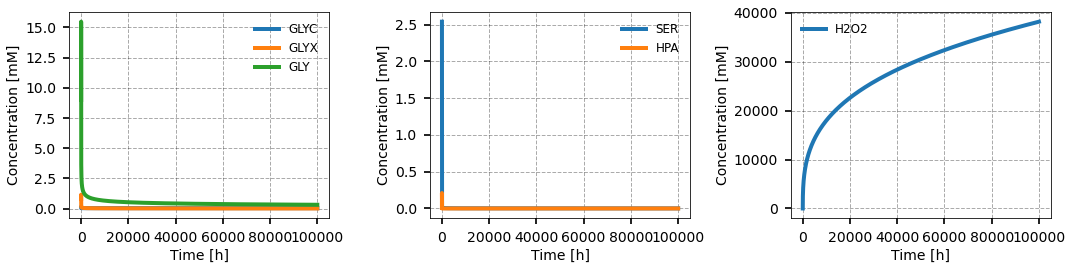

In [20]:
y0_yokota = {
    "GLYC": 0.08999999999999997,
    "GLYX": 0.7964601794673895,
    "GLY": 8.999999975082668,
    "SER": 2.538560856085531,
    "HPA": 0.009782608672218024,
    "H2O2": 0.010880542843616853,
}

s = Simulator(m)
s.update_parameters(
    {
        "kf_glyoxylate_decarboxylation": 1,  # [1/mM * H]
        "kf_hpa_decarboxylation": 1,  # [1/mM * H]
    }
)
s.initialise(y0_yokota)
t, y = s.simulate(100_000)
fig, ax = s.plot_grid(
    [
        ["GLYC", "GLYX", "GLY"],
        ["SER", "HPA"],
        ["H2O2"],
    ],
    xlabels="Time [h]",
    ylabels="Concentration [mM]",
    sharey=False,
)
fig.tight_layout()
plt.show()

v = s.get_fluxes_df()
c = s.get_full_results_df()

## Notes

- Ok, reversibility doesn't do the trick

# Large model

- split chl and per to get different H2O2 pools, otherwise vAscorbate takes over scaveging the peroxisomal H2O2 pool, which really is just wrong

In [11]:
y0_40 = {
    "PGA_chl": 0.2328628726167606,
    "BPGA_chl": 0.00013498759025650417,
    "GAP_chl": 0.0032904179301378096,
    "DHAP_chl": 0.07238918990964993,
    "FBP_chl": 0.0016911532715904085,
    "F6P_chl": 0.09884061242668968,
    "G6P_chl": 0.22733340857304188,
    "G1P_chl": 0.013185337697026006,
    "SBP_chl": 0.0036294018488087667,
    "S7P_chl": 0.030049709575089786,
    "E4P_chl": 0.0038567200588313392,
    "X5P_chl": 0.007083494305802293,
    "R5P_chl": 0.011864852766777748,
    "RUBP_chl": 0.0005793740673780587,
    "RU5P_chl": 0.004745941073444529,
    "ATP_chl": 1.6614853196713115,
    "Fd_chl": 4.024502751346789,
    "H_lumen_chl": 0.002213534789209001,
    "LHC_chl": 0.7535919467836858,
    "NADPH_chl": 0.6096702539920869,
    "PC_chl": 1.10688304200406,
    "PQ_chl": 9.41357427924644,
    "Psbs_chl": 0.960772083959122,
    "Vx_chl": 0.9509067545521149,
    "TR_ox_chl": 0.9549629023383585,
    "E_inactive_chl": 4.136872632404961,
    "MDA_chl": 6.671781464506206e-08,
    "H2O2_chl": 3.9585404978210144e-08,
    "DHA_chl": 1.1063629141008023e-12,
    "GSSG_chl": 5.369952109559326e-13,
    "GLYC_chl": 0.0002528050840347904,
    "GLYX_per": 0.004407623717548885,
    "GLY_per": 5.275365420863161,
    "H2O2_per": 7.608058101210902e-05,
    "HPA_per": 6.328525492603827e-05,
    "SER_per": 0.8355449802309565,
    "2PG_chl": 7.982783887930496e-08,
    "GLYA_chl": 2.4318388714367108e-05,
    "CO2_chl": 1.9463257591969823,
    "HCO3_chl": 97.3162879598493,
}

y0_700 = {
    "PGA_chl": 2.25749269882132,
    "BPGA_chl": 0.0011264301856137532,
    "GAP_chl": 0.014326229364132265,
    "DHAP_chl": 0.31517696302572606,
    "FBP_chl": 0.03205859742227435,
    "F6P_chl": 1.4251646445613497,
    "G6P_chl": 3.2778786813505283,
    "G1P_chl": 0.19011696348956827,
    "SBP_chl": 0.13073061148524637,
    "S7P_chl": 0.3974270200182982,
    "E4P_chl": 0.03190652750139712,
    "X5P_chl": 0.05375225047556578,
    "R5P_chl": 0.09003501589207202,
    "RUBP_chl": 0.01820797814297251,
    "RU5P_chl": 0.03601400573478615,
    "ATP_chl": 1.57283634763496,
    "Fd_chl": 1.7844521208048743,
    "H_lumen_chl": 0.002571780546298045,
    "LHC_chl": 0.6876355180747163,
    "NADPH_chl": 0.6825727121939977,
    "PC_chl": 3.5629687951328295,
    "PQ_chl": 7.768750204904629,
    "Psbs_chl": 0.9411031699135516,
    "Vx_chl": 0.9019787137932154,
    "TR_ox_chl": 0.6998264122755875,
    "E_inactive_chl": 1.4993493284049457,
    "MDA_chl": 9.551405182146448e-06,
    "H2O2_chl": 5.651236551849048e-06,
    "DHA_chl": 2.2675069408138433e-08,
    "GSSG_chl": 1.1000037379024173e-08,
    "GLYC_chl": 0.014688150593525457,
    "GLYX_per": 0.22151850300234646,
    "GLY_per": 12.683452898870083,
    "H2O2_per": 0.003566084989264498,
    "HPA_per": 0.0030398211642407424,
    "SER_per": 1.3124054556006246,
    "2PG_chl": 3.7421060514968663e-06,
    "GLYA_chl": 0.005051296603623718,
    "CO2_chl": 1.0040099592269227,
    "HCO3_chl": 50.200497961345896,
}

# Wildtype

## Light-to-dark

In [20]:
m = models.get_c3_mesophyll(c_chl="_chl", c_per="_per", c_mit="_mit")
s = Simulator(m)
s.update_parameters(
    {
        "pfd": 40,
        "O2": 0.1,
        "CO2_ext": 2,
        "k_diffusion_co2": 3.7,  # rough fit to get rubisco to prior behaviour
    }
)
s.initialise(y0_700)
# t, y = s.simulate(100_000)
t, y = s.simulate(1000)

c = s.get_full_results_df()
v = s.get_fluxes_df()

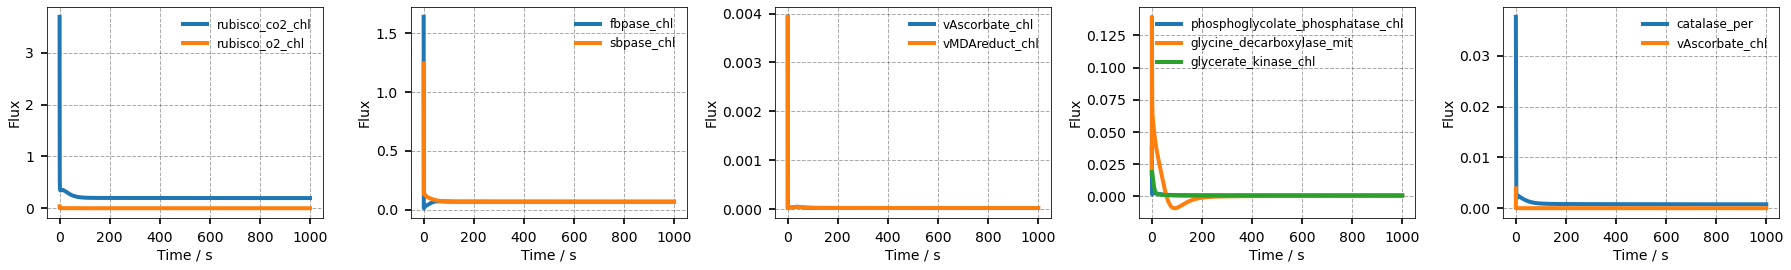

In [21]:
fig, axs = s.plot_fluxes_grid(
    [
        ["rubisco_co2_chl", "rubisco_o2_chl"],
        # cbb cycle
        ["fbpase_chl", "sbpase_chl"],
        # Mehler
        ["vAscorbate_chl", "vMDAreduct_chl"],
        # Photorespiration
        [
            "phosphoglycolate_phosphatase_chl",
            "glycine_decarboxylase_mit",
            "glycerate_kinase_chl",
        ],
        # H2O2 scaveging
        ["catalase_per", "vAscorbate_chl"],
    ],
    sharey=False,
    xlabels="Time / s",
    ylabels="Flux",
)

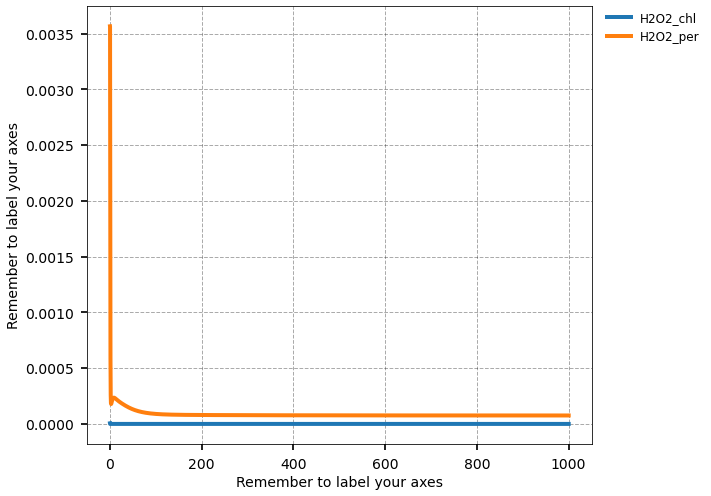

In [22]:
fig, axs = s.plot_selection(["H2O2_chl", "H2O2_per"])

# Mutant

## Light-to-dark

In [14]:
m = models.get_c3_mesophyll(c_chl="_chl", c_per="_per", c_mit="_mit")
m = add_nonenzymatic_decarboxylations(m, c_per="_per")
m = update_nonenzymatic_decarboxylations_dynamic_co2(m, c_chl="_chl", c_per="_per")
m.remove_reaction("catalase_per")


s = Simulator(m)
s.update_parameters(
    {
        "pfd": 40,
        "O2": 0.1,
        "CO2_ext": 2,
        "k_diffusion_co2": 3.7,  # rough fit to get rubisco to prior behaviour
        "kf_glyoxylate_decarboxylation": 1,  # [1/mM * s]
        "kf_hpa_decarboxylation": 1,  # [1/mM * s]
    }
)
s.initialise(y0_700)
# t, y = s.simulate(100_000)
t, y = s.simulate(1000)

c = s.get_full_results_df()
v = s.get_fluxes_df()

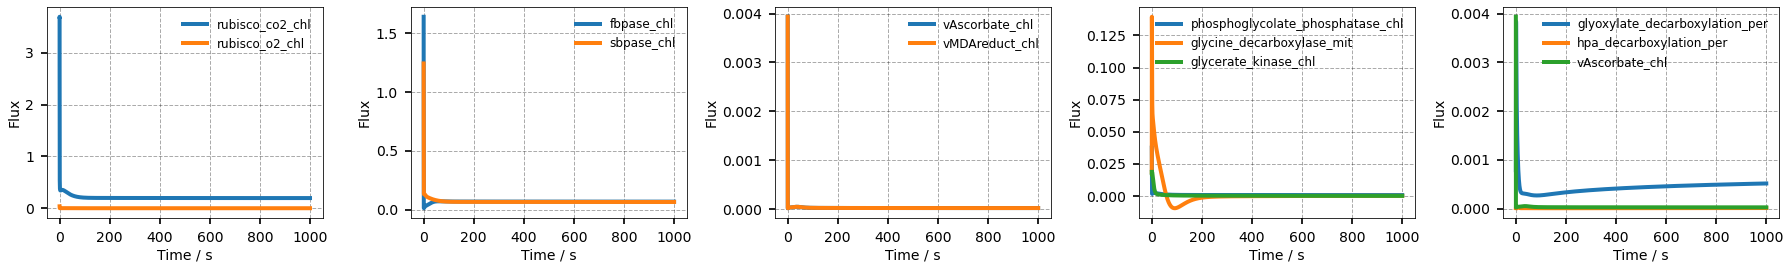

In [15]:
fig, axs = s.plot_fluxes_grid(
    [
        ["rubisco_co2_chl", "rubisco_o2_chl"],
        # cbb cycle
        ["fbpase_chl", "sbpase_chl"],
        # Mehler
        ["vAscorbate_chl", "vMDAreduct_chl"],
        # Photorespiration
        [
            "phosphoglycolate_phosphatase_chl",
            "glycine_decarboxylase_mit",
            "glycerate_kinase_chl",
        ],
        # H2O2 scaveging
        ["glyoxylate_decarboxylation_per", "hpa_decarboxylation_per", "vAscorbate_chl"],
    ],
    sharey=False,
    xlabels="Time / s",
    ylabels="Flux",
)

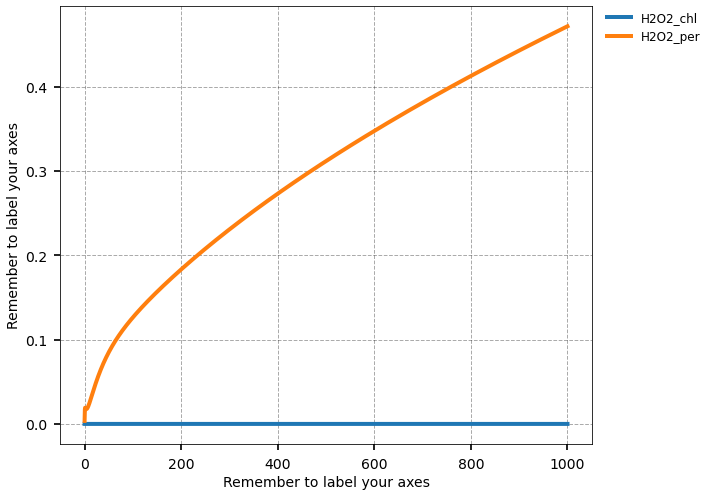

In [16]:
fig, axs = s.plot_selection(["H2O2_chl", "H2O2_per"])

## Dark to light

In [17]:
m = models.get_c3_mesophyll(c_chl="_chl", c_per="_per", c_mit="_mit")
m = add_nonenzymatic_decarboxylations(m, c_per="_per")
m = update_nonenzymatic_decarboxylations_dynamic_co2(m, c_chl="_chl", c_per="_per")
m.remove_reaction("catalase_per")


s = Simulator(m)
s.update_parameters(
    {
        "pfd": 700,
        "O2": 0.1,
        "CO2_ext": 2,
        "k_diffusion_co2": 3.7,  # rough fit to get rubisco to prior behaviour
        "kf_glyoxylate_decarboxylation": 1,  # [1/mM * s]
        "kf_hpa_decarboxylation": 1,  # [1/mM * s]
    }
)
s.initialise(y0_40)
# t, y = s.simulate(100_000)
t, y = s.simulate(90 * 60)

c = s.get_full_results_df()
v = s.get_fluxes_df()

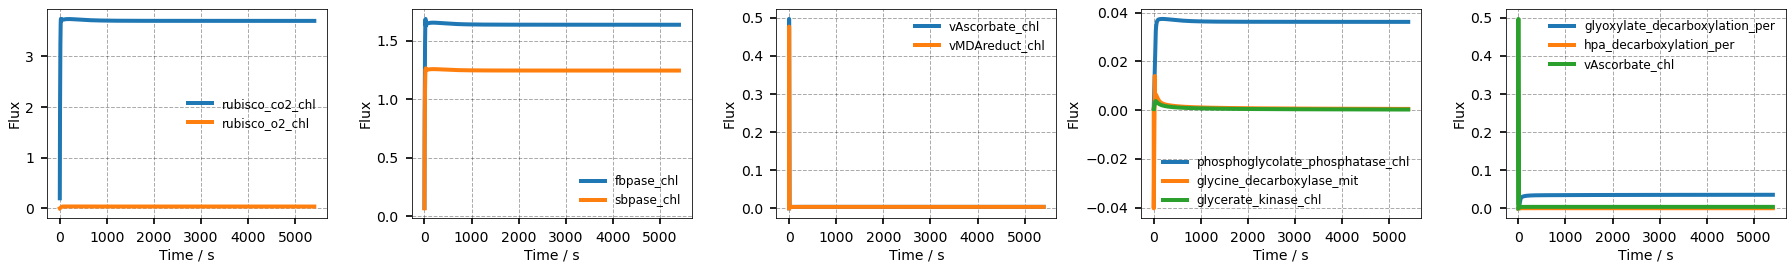

In [18]:
fig, axs = s.plot_fluxes_grid(
    [
        ["rubisco_co2_chl", "rubisco_o2_chl"],
        # cbb cycle
        ["fbpase_chl", "sbpase_chl"],
        # Mehler
        ["vAscorbate_chl", "vMDAreduct_chl"],
        # Photorespiration
        [
            "phosphoglycolate_phosphatase_chl",
            "glycine_decarboxylase_mit",
            "glycerate_kinase_chl",
        ],
        # H2O2 scaveging
        ["glyoxylate_decarboxylation_per", "hpa_decarboxylation_per", "vAscorbate_chl"],
    ],
    sharey=False,
    xlabels="Time / s",
    ylabels="Flux",
)

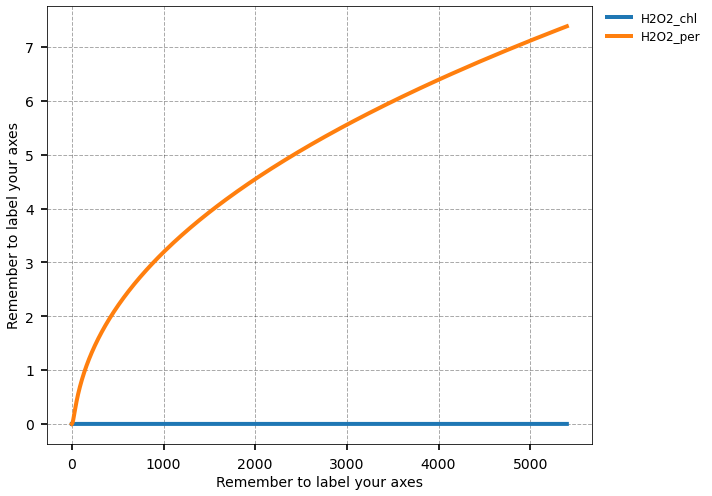

In [19]:
fig, axs = s.plot_selection(["H2O2_chl", "H2O2_per"])